In [ ]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tqdm.notebook import tqdm


data_dir = "./asl_alphabet_train/asl_alphabet_train"
batch_size = 32
num_epochs = 10
num_classes = 29
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# ========== Image preprocessing ==========
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.2, 0.2, 0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [3]:
# ===== Load and partition the dataset =====
full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)
total_len = len(full_dataset)
val_len = int(total_len * 0.15)
test_len = int(total_len * 0.15)
train_len = total_len - val_len - test_len

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_len, val_len, test_len])
val_dataset.dataset.transform = val_test_transform
test_dataset.dataset.transform = val_test_transform

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# ===== Fine-tuning ResNet18 =====
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Freeze all parameters except fc
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, num_classes)
)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-4,weight_decay=1e-4)

In [5]:
# ===== Training function =====
def train_model(model, train_loader, val_loader, epochs):
    best_acc = 0.0
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(epochs):

        model.train()
        running_loss, running_corrects = 0.0, 0

        for inputs, labels in tqdm(train_loader,
                                  desc=f"Epoch {epoch+1}/{epochs} Train",
                                  leave=False, dynamic_ncols=True):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels)

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = running_corrects.double() / len(train_loader.dataset)
        

        # Validation
        model.eval()
        val_running_loss, val_corrects = 0.0, 0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validation", leave=False):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels)

        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)
        

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc.item())
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc.item())
        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f} Train Acc={train_acc:.4f} | Val Loss={val_loss:.4f} Val Acc={val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            os.makedirs("models", exist_ok=True)
            torch.save(model.state_dict(), "models/best_resnet18.pth")
           

    return history

In [6]:
# ===== Drawing functions =====
def plot_history(history):
    epochs_range = range(1, len(history["train_loss"]) + 1)
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history["train_loss"], label='Train Loss')
    plt.plot(epochs_range, history["val_loss"], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history["train_acc"], label='Train Accuracy')
    plt.plot(epochs_range, history["val_acc"], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

Epoch 1/10 Train:   0%|                                                                       | 0/1904 [00:00<…

Validation:   0%|          | 0/408 [00:00<?, ?it/s]

Epoch 1: Train Loss=1.4283 Train Acc=0.6728 | Val Loss=0.5357 Val Acc=0.8910


Epoch 2/10 Train:   0%|                                                                       | 0/1904 [00:00<…

Validation:   0%|          | 0/408 [00:00<?, ?it/s]

Epoch 2: Train Loss=0.4998 Train Acc=0.8714 | Val Loss=0.2979 Val Acc=0.9309


Epoch 3/10 Train:   0%|                                                                       | 0/1904 [00:00<…

Validation:   0%|          | 0/408 [00:00<?, ?it/s]

Epoch 3: Train Loss=0.3294 Train Acc=0.9102 | Val Loss=0.2006 Val Acc=0.9507


Epoch 4/10 Train:   0%|                                                                       | 0/1904 [00:00<…

Validation:   0%|          | 0/408 [00:00<?, ?it/s]

Epoch 4: Train Loss=0.2527 Train Acc=0.9289 | Val Loss=0.1655 Val Acc=0.9581


Epoch 5/10 Train:   0%|                                                                       | 0/1904 [00:00<…

Validation:   0%|          | 0/408 [00:00<?, ?it/s]

Epoch 5: Train Loss=0.2094 Train Acc=0.9395 | Val Loss=0.1314 Val Acc=0.9654


Epoch 6/10 Train:   0%|                                                                       | 0/1904 [00:00<…

Validation:   0%|          | 0/408 [00:00<?, ?it/s]

Epoch 6: Train Loss=0.1779 Train Acc=0.9478 | Val Loss=0.1080 Val Acc=0.9711


Epoch 7/10 Train:   0%|                                                                       | 0/1904 [00:00<…

Validation:   0%|          | 0/408 [00:00<?, ?it/s]

Epoch 7: Train Loss=0.1559 Train Acc=0.9540 | Val Loss=0.0949 Val Acc=0.9755


Epoch 8/10 Train:   0%|                                                                       | 0/1904 [00:00<…

Validation:   0%|          | 0/408 [00:00<?, ?it/s]

Epoch 8: Train Loss=0.1377 Train Acc=0.9600 | Val Loss=0.0849 Val Acc=0.9766


Epoch 9/10 Train:   0%|                                                                       | 0/1904 [00:00<…

Validation:   0%|          | 0/408 [00:00<?, ?it/s]

Epoch 9: Train Loss=0.1254 Train Acc=0.9625 | Val Loss=0.0781 Val Acc=0.9798


Epoch 10/10 Train:   0%|                                                                      | 0/1904 [00:00<…

Validation:   0%|          | 0/408 [00:00<?, ?it/s]

Epoch 10: Train Loss=0.1123 Train Acc=0.9667 | Val Loss=0.0700 Val Acc=0.9795


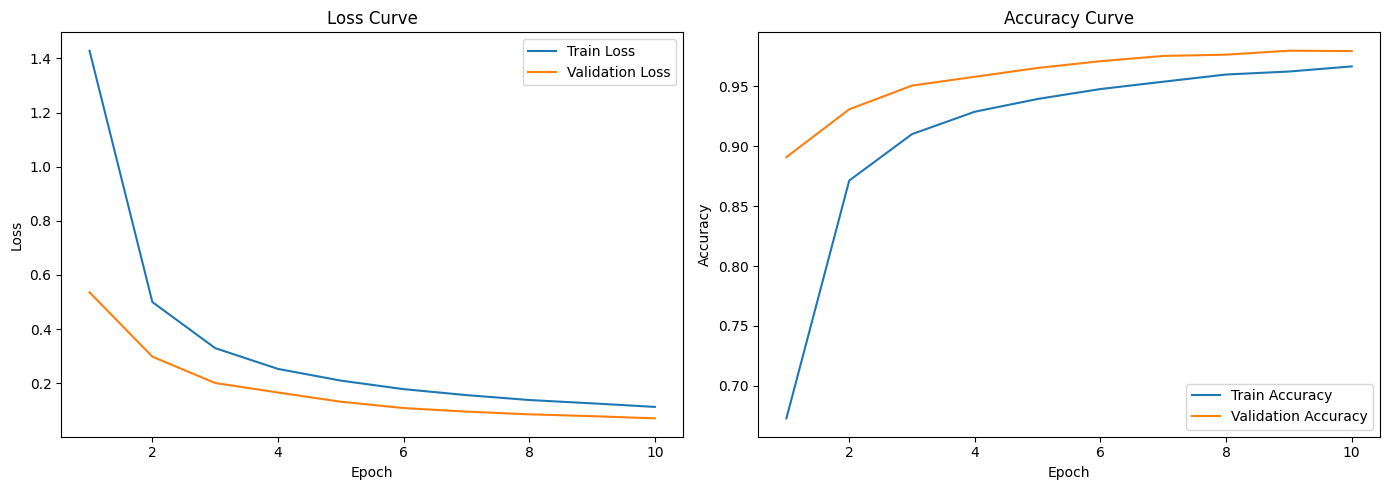

In [31]:
# ========== Train and visualize ==========
history = train_model(model, train_loader, val_loader, num_epochs)
plot_history(history)

In [7]:
# ========== Model Evaluation ==========
model = models.resnet18(weights=None)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, num_classes)
)
model.load_state_dict(torch.load("models/best_resnet18.pth", map_location=device))
model = model.to(device)
model.eval()

C:\Users\Manson\AppData\Local\Temp\ipykernel_23288\2081451995.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("models/best_resnet18.pth"

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')
acc = accuracy_score(all_labels, all_preds)

print(f"\nPrecision = {precision:.4f}")
print(f"Recall    = {recall:.4f}")
print(f"F1        = {f1:.4f}")
print(f"Accuracy  = {acc:.2%}")


Precision = 0.9827
Recall    = 0.9825
F1        = 0.9824
Accuracy  = 98.25%


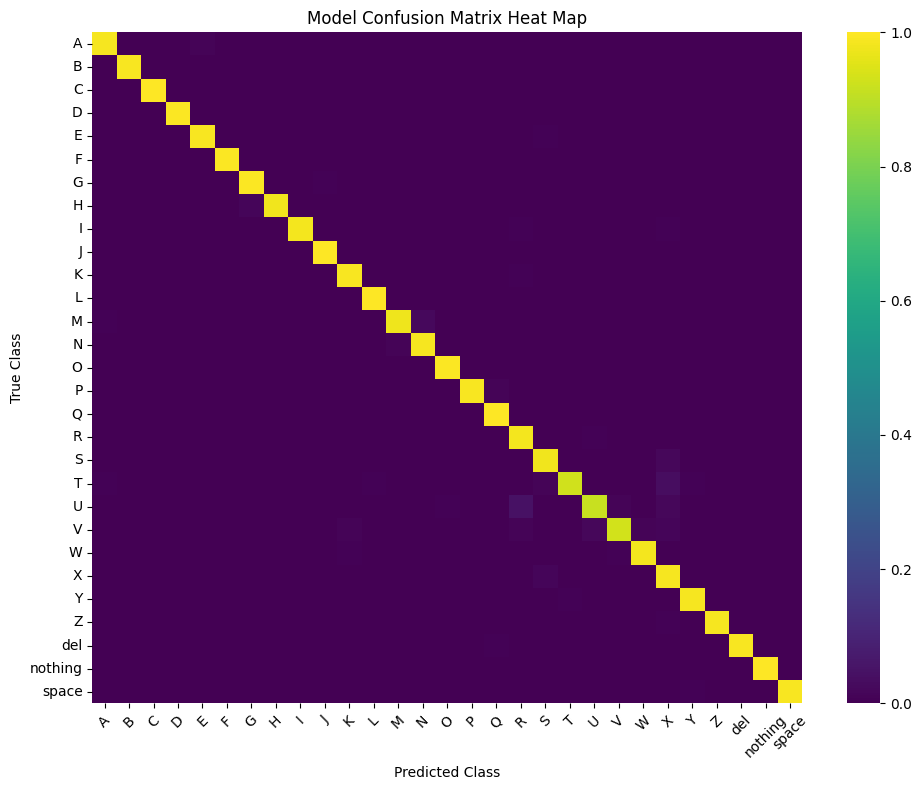


Classification Report:


NameError: name 'classification_report' is not defined

In [9]:
# ===== Confusion Matrix Visualization =====
cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, cmap="viridis", cbar=True,
            xticklabels=full_dataset.classes, yticklabels=full_dataset.classes)
plt.title("Model Confusion Matrix Heat Map")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# ========== Classification Report ==========
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=full_dataset.classes))